In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pykalman import KalmanFilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
X_columns = ['temperature', 'cpu_percent', 'fan_rpm', 'sys_load_1', 'cpu_freq']
y_column = 'next_temp'

In [54]:
def get_data(filename):
    """
    Read the given CSV file. Returns sysinfo DataFrame with target (next temperature) column created.
    """
    sysinfo = pd.read_csv(filename, parse_dates=['timestamp'])
    
    # TODO: add the column that we want to predict: the temperatures from the *next* time step.
    sysinfo[y_column] = sysinfo['temperature'].shift(periods=-1) # should be the temperature value from the next row
    sysinfo = sysinfo[sysinfo[y_column].notnull()] # the last row should have y_column null: no next temp known
    return sysinfo


def get_trained_coefficients(X_train, y_train):
    """
    Create and train a model based on the training_data_file data.

    Return the model, and the list of coefficients for the 'X_columns' variables in the regression.
    """
    
    # TODO: create regression model and train.
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    coefficients = model.coef_
    return model, coefficients


def output_regression(coefficients):
    regress = ' + '.join(f'{coef:.3}*{col}' for col, coef in zip(X_columns, coefficients))
    print(f'next_temp = {regress}')


def plot_errors(model, X_valid, y_valid):
    residuals = y_valid - model.predict(X_valid)
    plt.hist(residuals, bins=100)
    plt.savefig('test_errors.png')
    plt.close()


def smooth_test(coef, sysinfo, outfile):
    X_valid, y_valid = sysinfo[X_columns], sysinfo[y_column]
    
    # feel free to tweak these if you think it helps.
    transition_stddev = 0.4
    observation_stddev = 1.1

    dims = X_valid.shape[-1]
    initial = X_valid.iloc[0]
    observation_covariance = np.diag([observation_stddev, 2, 2, 1, 10]) ** 2
    transition_covariance = np.diag([transition_stddev, 80, 100, 10, 100]) ** 2
    
    # Transition = identity for all variables, except we'll replace the top row
    # to make a better prediction, which was the point of all this.
    transition = np.identity(dims) # identity matrix, except...
    
    # TODO: replace the first row of transition to use the coefficients we just calculated (which were passed into this function as coef.).
    transition[0] = coef
    
    kf = KalmanFilter(
        initial_state_mean=initial,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance,
        transition_matrices=transition,
    )

    kalman_smoothed, _ = kf.smooth(X_valid)

    plt.figure(figsize=(15, 6))
    plt.plot(sysinfo['timestamp'], sysinfo['temperature'], 'b.', alpha=0.5)
    plt.plot(sysinfo['timestamp'], kalman_smoothed[:, 0], 'g-')
    plt.savefig(outfile)
    plt.close()



    

In [4]:
# train = get_data("sysinfo-train.csv")
# valid = get_data("sysinfo-valid.csv")
# X_train, y_train = train[X_columns], train[y_column]
# X_valid, y_valid = valid[X_columns], valid[y_column]

# model, coefficients = get_trained_coefficients(X_train, y_train)
# output_regression(coefficients)
# #smooth_test(coefficients, train, 'train.png')

# #print(f"Training score: {model.score(X_train, y_train)}\nValidation score: {model.score(X_valid, y_valid)}")

# plot_errors(model, X_valid, y_valid)
# smooth_test(coefficients, valid, 'valid.png')

In [19]:
train = get_data("sysinfo-train.csv")
valid = get_data("sysinfo-valid.csv")

In [21]:
X_train, y_train = train[X_columns], train[y_column]
X_valid, y_valid = valid[X_columns], valid[y_column]

In [49]:
# poly = PolynomialFeatures(degree=11, include_bias=True)
# X_poly = poly.fit_transform(X_train)
# model = LinearRegression(fit_intercept=False)
# model.fit(X_poly, y_train)
# print(model.coef_)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
print(model.coef_)
plt.plot(train['timestamp'], y_train, 'b.')
plt.plot(train['timestamp'], model.predict(X_train), 'r-')

[ 2.56478455e-25  1.15955793e-25 -6.15652488e-27 ...  2.07950857e-30
  4.39244648e-32 -4.00334966e-34]


In [55]:
model, coefficients = get_trained_coefficients(X_train, y_train)
output_regression(coefficients)

next_temp = 0.596*temperature + -0.127*cpu_percent + 0.0163*fan_rpm + 0.727*sys_load_1 + 0.000274*cpu_freq


[[ 5.96299639e-01 -1.26922795e-01  1.62989305e-02  7.26935176e-01
   2.74112833e-04]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]]


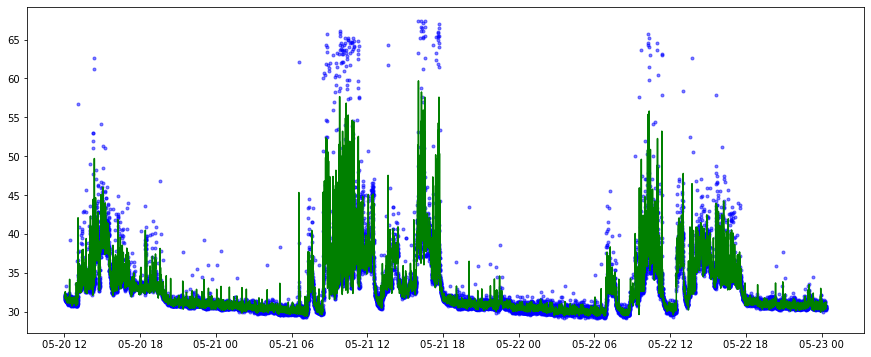

In [58]:
X_valid, y_valid = sysinfo[X_columns], sysinfo[y_column]
    
# feel free to tweak these if you think it helps.
transition_stddev = 0.4
observation_stddev = 1.1

dims = X_valid.shape[-1]
initial = X_valid.iloc[0]
observation_covariance = np.diag([observation_stddev, 2, 2, 1, 10]) ** 2
transition_covariance = np.diag([transition_stddev, 80, 100, 10, 100]) ** 2

# Transition = identity for all variables, except we'll replace the top row
# to make a better prediction, which was the point of all this.
transition = np.identity(dims) # identity matrix, except...
transition[0] = coefficients
print(transition)
# TODO: replace the first row of transition to use the coefficients we just calculated (which were passed into this function as coef.).

kf = KalmanFilter(
    initial_state_mean=initial,
    initial_state_covariance=observation_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    transition_matrices=transition,
)

kalman_smoothed, _ = kf.smooth(X_valid)

plt.figure(figsize=(15, 6))
plt.plot(sysinfo['timestamp'], sysinfo['temperature'], 'b.', alpha=0.5)
plt.plot(sysinfo['timestamp'], kalman_smoothed[:, 0], 'g-')
plt.show()
# plt.savefig(outfile)
plt.close()